# Multiple Regression

Let's grab a small little data set of Blue Book car values:

In [1]:
import pandas as pd

df = pd.read_excel('http://cdn.sundog-soft.com/Udemy/DataScience/cars.xls')


                     Mileage         Price
Mileage                                   
(0, 10000]       5588.629630  24096.714451
(10000, 20000]  15898.496183  21955.979607
(20000, 30000]  24114.407104  20278.606252
(30000, 40000]  33610.338710  19463.670267


<AxesSubplot:xlabel='Mileage'>

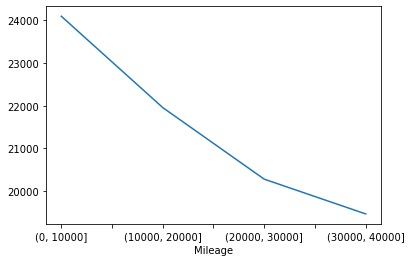

In [2]:
%matplotlib inline
import numpy as np
# Use Mileage and Price columns from the spreadsheet.
df1 = df[['Mileage','Price']]
# Bucket it up at 10000 miles intervals.
# arange(start, stop, step); returns an array of evenly spaced values.
# e.g., np.arange(0, 50, 10) returns [ 0 10 20 30 40].
bins =  np.arange(0,50000,10000)

# Compute the mean for each of the bins.

# pd.cut(x, bins): segment and sort data values into bins.
# x: input array to be binned; bins: criteria to bin by, with a sequence of scalars,
# they are the bin edges.
# Returns array-like object representing the respective bin for each value of x.

# DataFrame.groupby(by): group DataFrame.
# by: with an ndarray, the values are used as-is to determine the groups.
# Returns a groupby object that contains information about the groups.

# GroupBy.mean(): compute mean of groups.
# Returns a DataFrame

groups = df1.groupby(pd.cut(df1['Mileage'], bins)).mean()
# Show mean mileage and price for each of the mileage ranges.
print(groups.head())
# Plot mean price against mileage ranges.
groups['Price'].plot.line()

We can use pandas to split up this matrix into the feature vectors we're interested in, and the value we're trying to predict.

Note how we are avoiding the make and model; regressions don't work well with ordinal values, unless you can convert them into some numerical order that makes sense somehow.

Let's scale our feature data into the same range so we can easily compare the coefficients we end up with.

In [3]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

# Extract mileage, cylinder, and doors - feature variables/vectors.
# Convention: feature variables - uppercase 'X';
# thing we're trying to predict - lowercase 'y'.
X = df[['Mileage', 'Cylinder', 'Doors']]
y = df['Price']

# Scale data into a comparable range.
# fit_transform(): convert mileage, cylinder, and doors into uniform ranges between
# -1 and +1.
# Reasons:
# - a lot of models work best with normalised data
# - compare the coefficients apples to apples - look at the beta coefficients that
# we end up with and see their relative effects
X[['Mileage', 'Cylinder', 'Doors']] = scale.fit_transform(X[['Mileage', 'Cylinder', 'Doors']].values)

print(X)

# OLS: ordinary least squares
# Pass in the label data 'y' (prices) that we want to predict and the feature data
# 'X', and fit the data to the model (OLS).
est = sm.OLS(y, X).fit()

est.summary()
# The magnitude of the coefficients tells us that the number of cylinders (5587.4472)
# is the most important feature in predicting the sales prices. The more cylinders
# you have, the higher the price (positive coefficient). The more miles you have,
# the lower the price (negative coefficient).
# More doors, lower price: maybe it means sports cars sell for more money than
# 4-door sedans.

      Mileage  Cylinder     Doors
0   -1.417485   0.52741  0.556279
1   -1.305902   0.52741  0.556279
2   -0.810128   0.52741  0.556279
3   -0.426058   0.52741  0.556279
4    0.000008   0.52741  0.556279
..        ...       ...       ...
799 -0.439853   0.52741  0.556279
800 -0.089966   0.52741  0.556279
801  0.079605   0.52741  0.556279
802  0.750446   0.52741  0.556279
803  1.932565   0.52741  0.556279

[804 rows x 3 columns]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Price   R-squared (uncentered):                   0.064
Model:                            OLS   Adj. R-squared (uncentered):              0.060
Method:                 Least Squares   F-statistic:                              18.11
Date:                Wed, 03 Feb 2021   Prob (F-statistic):                    2.23e-11
Time:                        01:08:05   Log-Likelihood:                         -9207.1
No. Observations:                 804   AIC:                                  1.842e+04
Df Residuals:                     801   BIC:                                  1.843e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Mileage    -1272.3412    804.623     -1.581      0.114   -2851.759     307.077
Cylinder    5587.4472    804.509      6.945      0.000    4008.252    7166.642
Doors      -1404.5513    804.275     -1.746      0.081   -2983.288     174.185
==============================================================================
Omnibus:                      157.913   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              257.529
Skew:                           1.278   Prob(JB):                     1.20e-56
Kurtosis:                       4.074   Cond. No.                         1.03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The table of coefficients above gives us the values to plug into an equation of form:
    B0 + B1 * Mileage + B2 * cylinders + B3 * doors
    
In this example, it's pretty clear that the number of cylinders is more important than anything based on the coefficients.

Could we have figured that out earlier?

In [5]:
# For simplicity, we could have figured out the number of doors does not increase
# the sales price by grouping all the doors data and taking the mean of the prices
# associated with them.
y.groupby(df.Doors).mean()

Doors
2    23807.135520
4    20580.670749
Name: Price, dtype: float64

Surprisingly, more doors does not mean a higher price! (Maybe it implies a sport car in some cases?) So it's not surprising that it's pretty useless as a predictor here. This is a very small data set however, so we can't really read much meaning into it.

How would you use this to make an actual prediction? Start by scaling your multiple feature variables into the same scale used to train the model, then just call `est.predict()` on the scaled features:

In [7]:
# Scale the input features that you're trying to predict for into the same range
# that we used to make the models - use the same standard scaler instance, `scale`,
# and call its `transform` method, passing in the unscaled feature data (45000 miles,
# 8 cylinders, 4 doors) to get them down to the range we want.
scaled = scale.transform([[45000, 8, 4]])
print(scaled)

# Price prediction on the scaled feature data using the model (`est`).
predicted = est.predict(scaled[0])
print(predicted)

[[3.07256589 1.96971667 0.55627894]]
[6315.01330583]


Use `inverse_transform` to get back the original values.

In [8]:
print(scale.inverse_transform(scaled))

[[4.5e+04 8.0e+00 4.0e+00]]


## Activity

Mess around with the fake input data, and see if you can create a measurable influence of number of doors on price. Have some fun with it - why stop at 4 doors?